## Setup

In [2]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import torchvision.models as models

sys.path.insert(0, os.path.abspath('../'))

from src.augmentations import (
    get_baseline_transforms, 
    get_dg_transforms,
    get_eval_transforms,
    compare_augmentation_strategies
)
from src.dataset.loaders import get_dataloaders, compute_class_weights
from src.utils.metrics import calculate_metrics

SEED = 21
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
EPOCHS = 15  # Enough to see augmentation effect
IMG_SIZE = 224
LR = 1e-4

# Directories
NOTEBOOK_DIR = Path(os.getcwd())
RESULTS_DIR = NOTEBOOK_DIR / 'notebooks' / 'results' / 'style_randomization'
DATA_DIR = Path(os.getcwd()) / 'data'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Data directory: {DATA_DIR}")

Device: mps
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/style_randomization
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data


## Visualize Augmentation Strategies

Let's compare baseline vs DG augmentations to see the difference.

Visualizing augmentations on: healthy_399.jpg


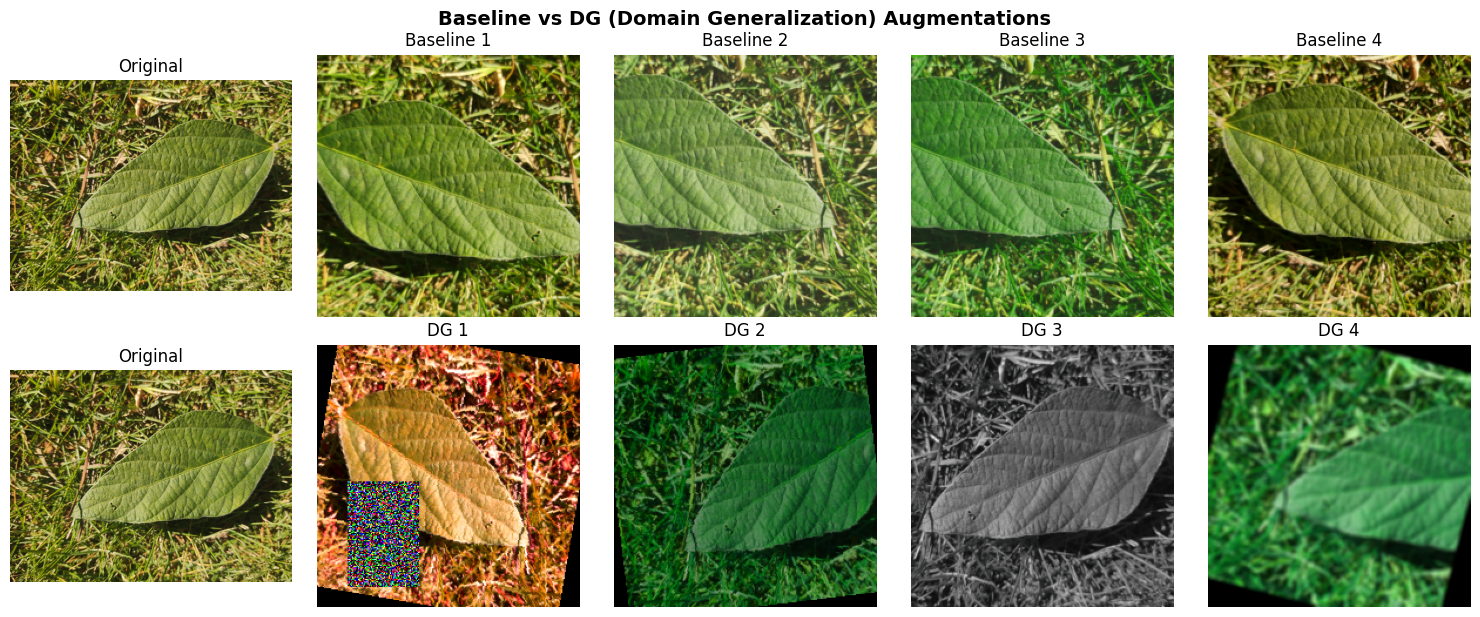


📊 Key differences:
  Baseline: Mild color jitter, basic crop/flip
  DG: Strong color jitter, blur, sharpening, JPEG artifacts, cutout, rotation


In [3]:
# Pick a sample image from ASDID (handle both .jpg and .JPG extensions)
sample_images = list((DATA_DIR / 'ASDID' / 'healthy').glob('*.[jJ][pP][gG]'))
if not sample_images:
    # Try other common extensions
    sample_images = list((DATA_DIR / 'ASDID' / 'healthy').glob('*.png'))
if not sample_images:
    raise FileNotFoundError("No image files found in ASDID/healthy directory")

sample_image = sample_images[0]
print(f"Visualizing augmentations on: {sample_image.name}")

fig = compare_augmentation_strategies(str(sample_image))
fig.suptitle('Baseline vs DG (Domain Generalization) Augmentations', fontsize=14, fontweight='bold', y=1.02)
plt.savefig(RESULTS_DIR / 'augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Key differences:")
print("  Baseline: Mild color jitter, basic crop/flip")
print("  DG: Strong color jitter, blur, sharpening, JPEG artifacts, cutout, rotation")

## Experiment 1: ResNet50 with Style Randomization

Train two ResNet50 models:
1. ResNet50 + Baseline augmentations
2. ResNet50 + DG augmentations

### 1.1 ResNet50 + Baseline Augmentations

In [5]:
print("="*70)
print("Training ResNet50 with BASELINE augmentations")
print("="*70)

# Load data with baseline transforms
train_transforms = get_baseline_transforms(img_size=IMG_SIZE)
eval_transforms = get_eval_transforms(img_size=IMG_SIZE)

train_loader, val_loader, test_loader, full_dataset, train_indices, val_indices, test_indices = get_dataloaders(
    dataset_name='ASDID',
    data_root=str(DATA_DIR / 'ASDID'),
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    test_transform=eval_transforms,
    seed=SEED
)

print(f"\nDataset: ASDID")
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")
print(f"Classes: {list(full_dataset.class_to_idx.keys())}")

Training ResNet50 with BASELINE augmentations
Loaded 4799 samples for ASDID dataset.
Loaded 4799 samples for ASDID dataset.

Dataset: ASDID
Train: 3359, Val: 719, Test: 721
Classes: ['Healthy', 'Rust', 'Frogeye']


In [6]:
# Initialize ResNet50
model_resnet_baseline = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_resnet_baseline.fc = nn.Linear(model_resnet_baseline.fc.in_features, 3)
model_resnet_baseline = model_resnet_baseline.to(DEVICE)

# Compute class weights
from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_indices)
class_weights, _ = compute_class_weights(train_dataset, num_classes=3)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model_resnet_baseline.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"\nModel: ResNet50 (25.6M params)")
print(f"Augmentation: Baseline")
print(f"Class weights: {class_weights}")

📊 Class distribution:
   Class 0: 1140 samples (weight: 0.982)
   Class 1: 1134 samples (weight: 0.987)
   Class 2: 1085 samples (weight: 1.031)

Model: ResNet50 (25.6M params)
Augmentation: Baseline
Class weights: tensor([0.9817, 0.9869, 1.0314])


/var/folders/nx/scf6msw549j5lvz4kv2gfpz00000gn/T/ipykernel_43279/4221163228.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)


In [8]:
# Training loop
best_val_f1 = 0.0
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(EPOCHS):
    # Training
    model_resnet_baseline.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_resnet_baseline(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{train_correct/train_total:.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(avg_train_loss)
    
    # Validation
    model_resnet_baseline.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_resnet_baseline(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    val_f1_scores.append(metrics['f1'])
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val F1: {metrics['f1']:.4f}")
    
    # Save best model
    if metrics['f1'] > best_val_f1:
        best_val_f1 = metrics['f1']
        torch.save(model_resnet_baseline.state_dict(), RESULTS_DIR / 'resnet50_baseline_best.pth')
        print(f"  ✅ Best model saved (F1: {best_val_f1:.4f})")
    
    scheduler.step()

print(f"\n✅ Training completed! Best Val F1: {best_val_f1:.4f}")

Epoch 1/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 1/15:
  Train Loss: 0.3997, Train Acc: 0.8678
  Val Loss: 0.0934, Val F1: 0.9706
  ✅ Best model saved (F1: 0.9706)


Epoch 2/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 2/15:
  Train Loss: 0.1158, Train Acc: 0.9598
  Val Loss: 0.0873, Val F1: 0.9719
  ✅ Best model saved (F1: 0.9719)


Epoch 3/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 3/15:
  Train Loss: 0.0789, Train Acc: 0.9738
  Val Loss: 0.0792, Val F1: 0.9777
  ✅ Best model saved (F1: 0.9777)


Epoch 4/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 4/15:
  Train Loss: 0.0560, Train Acc: 0.9827
  Val Loss: 0.0597, Val F1: 0.9790
  ✅ Best model saved (F1: 0.9790)


Epoch 5/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 5/15:
  Train Loss: 0.0580, Train Acc: 0.9812
  Val Loss: 0.0443, Val F1: 0.9803
  ✅ Best model saved (F1: 0.9803)


Epoch 6/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 6/15:
  Train Loss: 0.0373, Train Acc: 0.9878
  Val Loss: 0.0514, Val F1: 0.9778


Epoch 7/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 7/15:
  Train Loss: 0.0306, Train Acc: 0.9902
  Val Loss: 0.0504, Val F1: 0.9847
  ✅ Best model saved (F1: 0.9847)


Epoch 8/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 8/15:
  Train Loss: 0.0243, Train Acc: 0.9937
  Val Loss: 0.0418, Val F1: 0.9818


Epoch 9/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 9/15:
  Train Loss: 0.0225, Train Acc: 0.9920
  Val Loss: 0.0351, Val F1: 0.9861
  ✅ Best model saved (F1: 0.9861)


Epoch 10/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 10/15:
  Train Loss: 0.0189, Train Acc: 0.9949
  Val Loss: 0.0301, Val F1: 0.9874
  ✅ Best model saved (F1: 0.9874)


Epoch 11/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 11/15:
  Train Loss: 0.0201, Train Acc: 0.9935
  Val Loss: 0.0326, Val F1: 0.9831


Epoch 12/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 12/15:
  Train Loss: 0.0096, Train Acc: 0.9979
  Val Loss: 0.0307, Val F1: 0.9872


Epoch 13/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 13/15:
  Train Loss: 0.0096, Train Acc: 0.9970
  Val Loss: 0.0310, Val F1: 0.9872


Epoch 14/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 14/15:
  Train Loss: 0.0109, Train Acc: 0.9970
  Val Loss: 0.0321, Val F1: 0.9845


Epoch 15/15 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 15/15:
  Train Loss: 0.0088, Train Acc: 0.9967
  Val Loss: 0.0345, Val F1: 0.9888
  ✅ Best model saved (F1: 0.9888)

✅ Training completed! Best Val F1: 0.9888


### 1.2 ResNet50 + DG Augmentations

In [9]:
print("="*70)
print("Training ResNet50 with DG (Domain Generalization) augmentations")
print("="*70)

# Load data with DG transforms
train_transforms_dg = get_dg_transforms(img_size=IMG_SIZE)

train_loader_dg, val_loader_dg, test_loader_dg, full_dataset_dg, train_indices_dg, val_indices_dg, test_indices_dg = get_dataloaders(
    dataset_name='ASDID',
    data_root=str(DATA_DIR / 'ASDID'),
    batch_size=BATCH_SIZE,
    train_transform=train_transforms_dg,
    test_transform=eval_transforms,
    seed=SEED
)

print(f"\nDataset: ASDID")
print(f"Train: {len(train_indices_dg)}, Val: {len(val_indices_dg)}, Test: {len(test_indices_dg)}")

Training ResNet50 with DG (Domain Generalization) augmentations
Loaded 4799 samples for ASDID dataset.
Loaded 4799 samples for ASDID dataset.

Dataset: ASDID
Train: 3359, Val: 719, Test: 721


In [10]:
# Initialize ResNet50
model_resnet_dg = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_resnet_dg.fc = nn.Linear(model_resnet_dg.fc.in_features, 3)
model_resnet_dg = model_resnet_dg.to(DEVICE)

# Compute class weights
train_dataset_dg = Subset(full_dataset_dg, train_indices_dg)
class_weights_dg, _ = compute_class_weights(train_dataset_dg, num_classes=3)
class_weights_tensor_dg = torch.tensor(class_weights_dg, dtype=torch.float32).to(DEVICE)

criterion_dg = nn.CrossEntropyLoss(weight=class_weights_tensor_dg)
optimizer_dg = torch.optim.AdamW(model_resnet_dg.parameters(), lr=LR, weight_decay=0.01)
scheduler_dg = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_dg, T_max=EPOCHS)

print(f"\nModel: ResNet50 (25.6M params)")
print(f"Augmentation: DG (Heavy)")
print(f"Class weights: {class_weights_dg}")

📊 Class distribution:
   Class 0: 1140 samples (weight: 0.982)
   Class 1: 1134 samples (weight: 0.987)
   Class 2: 1085 samples (weight: 1.031)

Model: ResNet50 (25.6M params)
Augmentation: DG (Heavy)
Class weights: tensor([0.9817, 0.9869, 1.0314])


/var/folders/nx/scf6msw549j5lvz4kv2gfpz00000gn/T/ipykernel_43279/3178972808.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor_dg = torch.tensor(class_weights_dg, dtype=torch.float32).to(DEVICE)


In [11]:
# Training loop
best_val_f1_dg = 0.0
train_losses_dg = []
val_losses_dg = []
val_f1_scores_dg = []

for epoch in range(EPOCHS):
    # Training
    model_resnet_dg.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader_dg, desc=f"Epoch {epoch+1}/{EPOCHS} [Train DG]")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer_dg.zero_grad()
        outputs = model_resnet_dg(images)
        loss = criterion_dg(outputs, labels)
        loss.backward()
        optimizer_dg.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{train_correct/train_total:.4f}'})
    
    avg_train_loss = train_loss / len(train_loader_dg)
    train_acc = train_correct / train_total
    train_losses_dg.append(avg_train_loss)
    
    # Validation
    model_resnet_dg.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader_dg, desc=f"Epoch {epoch+1}/{EPOCHS} [Val DG]", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_resnet_dg(images)
            loss = criterion_dg(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader_dg)
    val_losses_dg.append(avg_val_loss)
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    val_f1_scores_dg.append(metrics['f1'])
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val F1: {metrics['f1']:.4f}")
    
    # Save best model
    if metrics['f1'] > best_val_f1_dg:
        best_val_f1_dg = metrics['f1']
        torch.save(model_resnet_dg.state_dict(), RESULTS_DIR / 'resnet50_dg_best.pth')
        print(f"  ✅ Best model saved (F1: {best_val_f1_dg:.4f})")
    
    scheduler_dg.step()

print(f"\n✅ Training completed! Best Val F1: {best_val_f1_dg:.4f}")

Epoch 1/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 1/15:
  Train Loss: 0.5866, Train Acc: 0.7794
  Val Loss: 0.1678, Val F1: 0.9445
  ✅ Best model saved (F1: 0.9445)


Epoch 2/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 2/15:
  Train Loss: 0.2595, Train Acc: 0.9047
  Val Loss: 0.0979, Val F1: 0.9702
  ✅ Best model saved (F1: 0.9702)


Epoch 3/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 3/15:
  Train Loss: 0.2169, Train Acc: 0.9217
  Val Loss: 0.0745, Val F1: 0.9804
  ✅ Best model saved (F1: 0.9804)


Epoch 4/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 4/15:
  Train Loss: 0.1751, Train Acc: 0.9336
  Val Loss: 0.0738, Val F1: 0.9762


Epoch 5/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 5/15:
  Train Loss: 0.1410, Train Acc: 0.9473
  Val Loss: 0.0725, Val F1: 0.9735


Epoch 6/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 6/15:
  Train Loss: 0.1479, Train Acc: 0.9443
  Val Loss: 0.0756, Val F1: 0.9719


Epoch 7/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 7/15:
  Train Loss: 0.1217, Train Acc: 0.9530
  Val Loss: 0.0723, Val F1: 0.9816
  ✅ Best model saved (F1: 0.9816)


Epoch 8/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 8/15:
  Train Loss: 0.1102, Train Acc: 0.9616
  Val Loss: 0.0705, Val F1: 0.9747


Epoch 9/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 9/15:
  Train Loss: 0.0957, Train Acc: 0.9649
  Val Loss: 0.0555, Val F1: 0.9790


Epoch 10/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 10/15:
  Train Loss: 0.0884, Train Acc: 0.9658
  Val Loss: 0.0548, Val F1: 0.9777


Epoch 11/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 11/15:
  Train Loss: 0.0800, Train Acc: 0.9714
  Val Loss: 0.0491, Val F1: 0.9819
  ✅ Best model saved (F1: 0.9819)


Epoch 12/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 12/15:
  Train Loss: 0.0704, Train Acc: 0.9777
  Val Loss: 0.0629, Val F1: 0.9748


Epoch 13/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 13/15:
  Train Loss: 0.0561, Train Acc: 0.9795
  Val Loss: 0.0549, Val F1: 0.9805


Epoch 14/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 14/15:
  Train Loss: 0.0669, Train Acc: 0.9768
  Val Loss: 0.0539, Val F1: 0.9819
  ✅ Best model saved (F1: 0.9819)


Epoch 15/15 [Train DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/15 [Val DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 15/15:
  Train Loss: 0.0656, Train Acc: 0.9783
  Val Loss: 0.0530, Val F1: 0.9819

✅ Training completed! Best Val F1: 0.9819


### 1.3 Evaluate ResNet50 Models on Cross-Domain Test Set (MH)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load MH dataset for testing
mh_mapping = {
    'Healthy_Soyabean': 'Healthy',
    'Soyabean_Rust': 'Rust',
    'Soyabean_Frog_Leaf_Eye': 'Frogeye'
}

_, _, mh_test_loader, mh_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    train_transform=eval_transforms,
    test_transform=eval_transforms,
    seed=SEED
)

print(f"MH Test Set: {len(mh_test_loader.dataset)} images")
print(f"Classes: {list(mh_dataset.class_to_idx.keys())}")

Loaded 1225 samples for MH dataset.
MH Test Set: 185 images
Classes: ['Healthy', 'Rust', 'Frogeye']


In [14]:
def evaluate_model(model, test_loader, model_name, device=DEVICE):
    """Evaluate model and return metrics"""
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Healthy', 'Rust', 'Frogeye'], digits=4)
    
    return metrics, cm, report

# Load best models
model_resnet_baseline.load_state_dict(torch.load(RESULTS_DIR / 'resnet50_baseline_best.pth'))
model_resnet_dg.load_state_dict(torch.load(RESULTS_DIR / 'resnet50_dg_best.pth'))

# Evaluate baseline
print("\n" + "="*70)
print("Evaluating ResNet50 + Baseline Augmentations on MH")
print("="*70)
metrics_baseline, cm_baseline, report_baseline = evaluate_model(model_resnet_baseline, mh_test_loader, "ResNet50-Baseline")

print(f"\nAccuracy:  {metrics_baseline['accuracy']:.4f}")
print(f"Precision: {metrics_baseline['precision']:.4f}")
print(f"Recall:    {metrics_baseline['recall']:.4f}")
print(f"F1 Score:  {metrics_baseline['f1']:.4f}")
print(f"\nPer-class Report:\n{report_baseline}")

# Evaluate DG
print("\n" + "="*70)
print("Evaluating ResNet50 + DG Augmentations on MH")
print("="*70)
metrics_dg, cm_dg, report_dg = evaluate_model(model_resnet_dg, mh_test_loader, "ResNet50-DG")

print(f"\nAccuracy:  {metrics_dg['accuracy']:.4f}")
print(f"Precision: {metrics_dg['precision']:.4f}")
print(f"Recall:    {metrics_dg['recall']:.4f}")
print(f"F1 Score:  {metrics_dg['f1']:.4f}")
print(f"\nPer-class Report:\n{report_dg}")


Evaluating ResNet50 + Baseline Augmentations on MH


Evaluating ResNet50-Baseline:   0%|          | 0/6 [00:00<?, ?it/s]


Accuracy:  0.8000
Precision: 0.7197
Recall:    0.7811
F1 Score:  0.7428

Per-class Report:
              precision    recall  f1-score   support

     Healthy     0.8824    1.0000    0.9375        30
        Rust     0.9052    0.8015    0.8502       131
     Frogeye     0.3714    0.5417    0.4407        24

    accuracy                         0.8000       185
   macro avg     0.7197    0.7811    0.7428       185
weighted avg     0.8322    0.8000    0.8112       185


Evaluating ResNet50 + DG Augmentations on MH


Evaluating ResNet50-DG:   0%|          | 0/6 [00:00<?, ?it/s]


Accuracy:  0.7946
Precision: 0.6910
Recall:    0.7558
F1 Score:  0.7178

Per-class Report:
              precision    recall  f1-score   support

     Healthy     0.7895    1.0000    0.8824        30
        Rust     0.8908    0.8092    0.8480       131
     Frogeye     0.3929    0.4583    0.4231        24

    accuracy                         0.7946       185
   macro avg     0.6910    0.7558    0.7178       185
weighted avg     0.8097    0.7946    0.7984       185



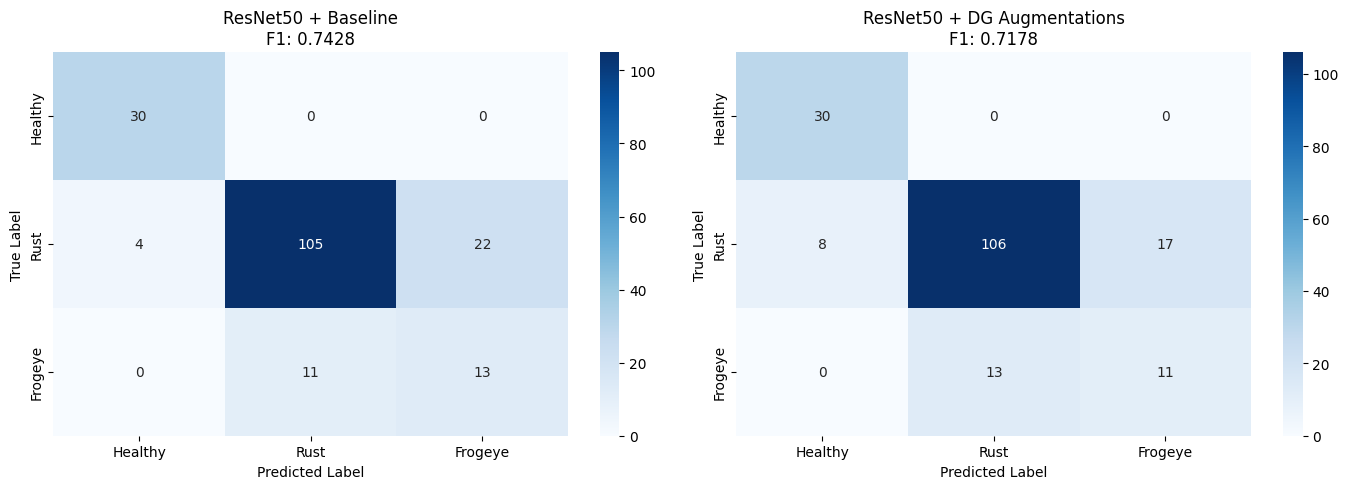


ResNet50 Results Summary (MH Cross-Domain)
Baseline F1:       0.7428
DG F1:             0.7178
Improvement:       -0.0250 (-3.4%)

❌ DG augmentations did not improve performance


In [15]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Healthy', 'Rust', 'Frogeye'],
            yticklabels=['Healthy', 'Rust', 'Frogeye'])
axes[0].set_title(f'ResNet50 + Baseline\nF1: {metrics_baseline["f1"]:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_dg, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Healthy', 'Rust', 'Frogeye'],
            yticklabels=['Healthy', 'Rust', 'Frogeye'])
axes[1].set_title(f'ResNet50 + DG Augmentations\nF1: {metrics_dg["f1"]:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'resnet50_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare F1 scores
resnet_f1_improvement = metrics_dg['f1'] - metrics_baseline['f1']
print(f"\n{'='*70}")
print(f"ResNet50 Results Summary (MH Cross-Domain)")
print(f"{'='*70}")
print(f"Baseline F1:       {metrics_baseline['f1']:.4f}")
print(f"DG F1:             {metrics_dg['f1']:.4f}")
print(f"Improvement:       {resnet_f1_improvement:+.4f} ({resnet_f1_improvement/metrics_baseline['f1']*100:+.1f}%)")
print(f"{'='*70}")

if resnet_f1_improvement > 0.03:
    print("\n✅ DG augmentations provide significant improvement!")
elif resnet_f1_improvement > 0:
    print("\n⚠️ DG augmentations provide modest improvement")
else:
    print("\n❌ DG augmentations did not improve performance")

## Experiment 2: ViT-B/16 with Style Randomization

Now test the same strategy with Vision Transformer.

### 2.1 ViT-B/16 + Baseline Augmentations

In [16]:
print("="*70)
print("Training ViT-B/16 with BASELINE augmentations")
print("="*70)

# Reload data (already have loaders from ResNet experiment)
# Initialize ViT-B/16
model_vit_baseline = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
model_vit_baseline.heads.head = nn.Linear(model_vit_baseline.heads.head.in_features, 3)
model_vit_baseline = model_vit_baseline.to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model_vit_baseline.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"\nModel: ViT-B/16 (86.6M params)")
print(f"Augmentation: Baseline")

Training ViT-B/16 with BASELINE augmentations

Model: ViT-B/16 (86.6M params)
Augmentation: Baseline


In [18]:
# Training loop
best_val_f1_vit = 0.0

for epoch in range(EPOCHS):
    # Training
    model_vit_baseline.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train ViT]")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_vit_baseline(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{train_correct/train_total:.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation
    model_vit_baseline.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val ViT]", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_vit_baseline(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val F1: {metrics['f1']:.4f}")
    
    # Save best model
    if metrics['f1'] > best_val_f1_vit:
        best_val_f1_vit = metrics['f1']
        torch.save(model_vit_baseline.state_dict(), RESULTS_DIR / 'vit_b_16_baseline_best.pth')
        print(f"  ✅ Best model saved (F1: {best_val_f1_vit:.4f})")
    
    scheduler.step()

print(f"\n✅ Training completed! Best Val F1: {best_val_f1_vit:.4f}")

Epoch 1/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 1/15:
  Train Loss: 0.1084, Train Acc: 0.9625
  Val Loss: 0.0869, Val F1: 0.9627
  ✅ Best model saved (F1: 0.9627)


Epoch 2/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 2/15:
  Train Loss: 0.1044, Train Acc: 0.9631
  Val Loss: 0.0850, Val F1: 0.9623


Epoch 3/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 3/15:
  Train Loss: 0.0835, Train Acc: 0.9726
  Val Loss: 0.0776, Val F1: 0.9720
  ✅ Best model saved (F1: 0.9720)


Epoch 4/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 4/15:
  Train Loss: 0.0871, Train Acc: 0.9664
  Val Loss: 0.0654, Val F1: 0.9734
  ✅ Best model saved (F1: 0.9734)


Epoch 5/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 5/15:
  Train Loss: 0.0582, Train Acc: 0.9789
  Val Loss: 0.0716, Val F1: 0.9749
  ✅ Best model saved (F1: 0.9749)


Epoch 6/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 6/15:
  Train Loss: 0.0444, Train Acc: 0.9839
  Val Loss: 0.0797, Val F1: 0.9745


Epoch 7/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 7/15:
  Train Loss: 0.0302, Train Acc: 0.9890
  Val Loss: 0.0566, Val F1: 0.9804
  ✅ Best model saved (F1: 0.9804)


Epoch 8/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 8/15:
  Train Loss: 0.0338, Train Acc: 0.9884
  Val Loss: 0.0584, Val F1: 0.9820
  ✅ Best model saved (F1: 0.9820)


Epoch 9/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 9/15:
  Train Loss: 0.0168, Train Acc: 0.9943
  Val Loss: 0.0394, Val F1: 0.9889
  ✅ Best model saved (F1: 0.9889)


Epoch 10/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 10/15:
  Train Loss: 0.0160, Train Acc: 0.9935
  Val Loss: 0.0455, Val F1: 0.9888


Epoch 11/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 11/15:
  Train Loss: 0.0082, Train Acc: 0.9973
  Val Loss: 0.0430, Val F1: 0.9888


Epoch 12/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 12/15:
  Train Loss: 0.0062, Train Acc: 0.9979
  Val Loss: 0.0439, Val F1: 0.9874


Epoch 13/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 13/15:
  Train Loss: 0.0057, Train Acc: 0.9985
  Val Loss: 0.0448, Val F1: 0.9887


Epoch 14/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 14/15:
  Train Loss: 0.0042, Train Acc: 0.9988
  Val Loss: 0.0407, Val F1: 0.9874


Epoch 15/15 [Train ViT]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/15 [Val ViT]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 15/15:
  Train Loss: 0.0029, Train Acc: 0.9988
  Val Loss: 0.0404, Val F1: 0.9874

✅ Training completed! Best Val F1: 0.9889


### 2.2 ViT-B/16 + DG Augmentations

In [19]:
print("="*70)
print("Training ViT-B/16 with DG (Domain Generalization) augmentations")
print("="*70)

# Initialize ViT-B/16
model_vit_dg = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
model_vit_dg.heads.head = nn.Linear(model_vit_dg.heads.head.in_features, 3)
model_vit_dg = model_vit_dg.to(DEVICE)

criterion_dg = nn.CrossEntropyLoss(weight=class_weights_tensor_dg)
optimizer_dg = torch.optim.AdamW(model_vit_dg.parameters(), lr=LR, weight_decay=0.01)
scheduler_dg = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_dg, T_max=EPOCHS)

print(f"\nModel: ViT-B/16 (86.6M params)")
print(f"Augmentation: DG (Heavy)")

Training ViT-B/16 with DG (Domain Generalization) augmentations

Model: ViT-B/16 (86.6M params)
Augmentation: DG (Heavy)


In [20]:
# Training loop
best_val_f1_vit_dg = 0.0

for epoch in range(EPOCHS):
    # Training
    model_vit_dg.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader_dg, desc=f"Epoch {epoch+1}/{EPOCHS} [Train ViT DG]")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer_dg.zero_grad()
        outputs = model_vit_dg(images)
        loss = criterion_dg(outputs, labels)
        loss.backward()
        optimizer_dg.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{train_correct/train_total:.4f}'})
    
    avg_train_loss = train_loss / len(train_loader_dg)
    train_acc = train_correct / train_total
    
    # Validation
    model_vit_dg.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader_dg, desc=f"Epoch {epoch+1}/{EPOCHS} [Val ViT DG]", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model_vit_dg(images)
            loss = criterion_dg(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader_dg)
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    
    print(f"\nEpoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val F1: {metrics['f1']:.4f}")
    
    # Save best model
    if metrics['f1'] > best_val_f1_vit_dg:
        best_val_f1_vit_dg = metrics['f1']
        torch.save(model_vit_dg.state_dict(), RESULTS_DIR / 'vit_b_16_dg_best.pth')
        print(f"  ✅ Best model saved (F1: {best_val_f1_vit_dg:.4f})")
    
    scheduler_dg.step()

print(f"\n✅ Training completed! Best Val F1: {best_val_f1_vit_dg:.4f}")

Epoch 1/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 1/15:
  Train Loss: 0.4914, Train Acc: 0.7940
  Val Loss: 0.1504, Val F1: 0.9479
  ✅ Best model saved (F1: 0.9479)


Epoch 2/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 2/15:
  Train Loss: 0.2565, Train Acc: 0.9024
  Val Loss: 0.0949, Val F1: 0.9634
  ✅ Best model saved (F1: 0.9634)


Epoch 3/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 3/15:
  Train Loss: 0.2204, Train Acc: 0.9193
  Val Loss: 0.1496, Val F1: 0.9388


Epoch 4/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 4/15:
  Train Loss: 0.1902, Train Acc: 0.9297
  Val Loss: 0.1441, Val F1: 0.9439


Epoch 5/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 5/15:
  Train Loss: 0.1560, Train Acc: 0.9408
  Val Loss: 0.0964, Val F1: 0.9632


Epoch 6/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 6/15:
  Train Loss: 0.1451, Train Acc: 0.9482
  Val Loss: 0.0679, Val F1: 0.9732
  ✅ Best model saved (F1: 0.9732)


Epoch 7/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 7/15:
  Train Loss: 0.1212, Train Acc: 0.9550
  Val Loss: 0.0896, Val F1: 0.9662


Epoch 8/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 8/15:
  Train Loss: 0.0976, Train Acc: 0.9613
  Val Loss: 0.0745, Val F1: 0.9761
  ✅ Best model saved (F1: 0.9761)


Epoch 9/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 9/15:
  Train Loss: 0.0765, Train Acc: 0.9720
  Val Loss: 0.0659, Val F1: 0.9787
  ✅ Best model saved (F1: 0.9787)


Epoch 10/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 10/15:
  Train Loss: 0.0644, Train Acc: 0.9783
  Val Loss: 0.0590, Val F1: 0.9773


Epoch 11/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 11/15:
  Train Loss: 0.0412, Train Acc: 0.9854
  Val Loss: 0.0670, Val F1: 0.9789
  ✅ Best model saved (F1: 0.9789)


Epoch 12/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 12/15:
  Train Loss: 0.0347, Train Acc: 0.9878
  Val Loss: 0.0555, Val F1: 0.9845
  ✅ Best model saved (F1: 0.9845)


Epoch 13/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 13/15:
  Train Loss: 0.0405, Train Acc: 0.9839
  Val Loss: 0.0537, Val F1: 0.9801


Epoch 14/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 14/15:
  Train Loss: 0.0276, Train Acc: 0.9899
  Val Loss: 0.0520, Val F1: 0.9844


Epoch 15/15 [Train ViT DG]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/15 [Val ViT DG]:   0%|          | 0/23 [00:00<?, ?it/s]


Epoch 15/15:
  Train Loss: 0.0235, Train Acc: 0.9920
  Val Loss: 0.0519, Val F1: 0.9844

✅ Training completed! Best Val F1: 0.9845


### 2.3 Evaluate ViT Models on Cross-Domain Test Set (MH)

In [21]:
# Load best models
model_vit_baseline.load_state_dict(torch.load(RESULTS_DIR / 'vit_b_16_baseline_best.pth'))
model_vit_dg.load_state_dict(torch.load(RESULTS_DIR / 'vit_b_16_dg_best.pth'))

# Evaluate baseline
print("\n" + "="*70)
print("Evaluating ViT-B/16 + Baseline Augmentations on MH")
print("="*70)
vit_metrics_baseline, vit_cm_baseline, vit_report_baseline = evaluate_model(model_vit_baseline, mh_test_loader, "ViT-Baseline")

print(f"\nAccuracy:  {vit_metrics_baseline['accuracy']:.4f}")
print(f"Precision: {vit_metrics_baseline['precision']:.4f}")
print(f"Recall:    {vit_metrics_baseline['recall']:.4f}")
print(f"F1 Score:  {vit_metrics_baseline['f1']:.4f}")
print(f"\nPer-class Report:\n{vit_report_baseline}")

# Evaluate DG
print("\n" + "="*70)
print("Evaluating ViT-B/16 + DG Augmentations on MH")
print("="*70)
vit_metrics_dg, vit_cm_dg, vit_report_dg = evaluate_model(model_vit_dg, mh_test_loader, "ViT-DG")

print(f"\nAccuracy:  {vit_metrics_dg['accuracy']:.4f}")
print(f"Precision: {vit_metrics_dg['precision']:.4f}")
print(f"Recall:    {vit_metrics_dg['recall']:.4f}")
print(f"F1 Score:  {vit_metrics_dg['f1']:.4f}")
print(f"\nPer-class Report:\n{vit_report_dg}")


Evaluating ViT-B/16 + Baseline Augmentations on MH


Evaluating ViT-Baseline:   0%|          | 0/6 [00:00<?, ?it/s]


Accuracy:  0.7405
Precision: 0.7150
Recall:    0.7559
F1 Score:  0.7133

Per-class Report:
              precision    recall  f1-score   support

     Healthy     0.9667    0.9667    0.9667        30
        Rust     0.9038    0.7176    0.8000       131
     Frogeye     0.2745    0.5833    0.3733        24

    accuracy                         0.7405       185
   macro avg     0.7150    0.7559    0.7133       185
weighted avg     0.8324    0.7405    0.7717       185


Evaluating ViT-B/16 + DG Augmentations on MH


Evaluating ViT-DG:   0%|          | 0/6 [00:00<?, ?it/s]


Accuracy:  0.7892
Precision: 0.6574
Recall:    0.6966
F1 Score:  0.6742

Per-class Report:
              precision    recall  f1-score   support

     Healthy     0.8333    1.0000    0.9091        30
        Rust     0.8661    0.8397    0.8527       131
     Frogeye     0.2727    0.2500    0.2609        24

    accuracy                         0.7892       185
   macro avg     0.6574    0.6966    0.6742       185
weighted avg     0.7838    0.7892    0.7851       185



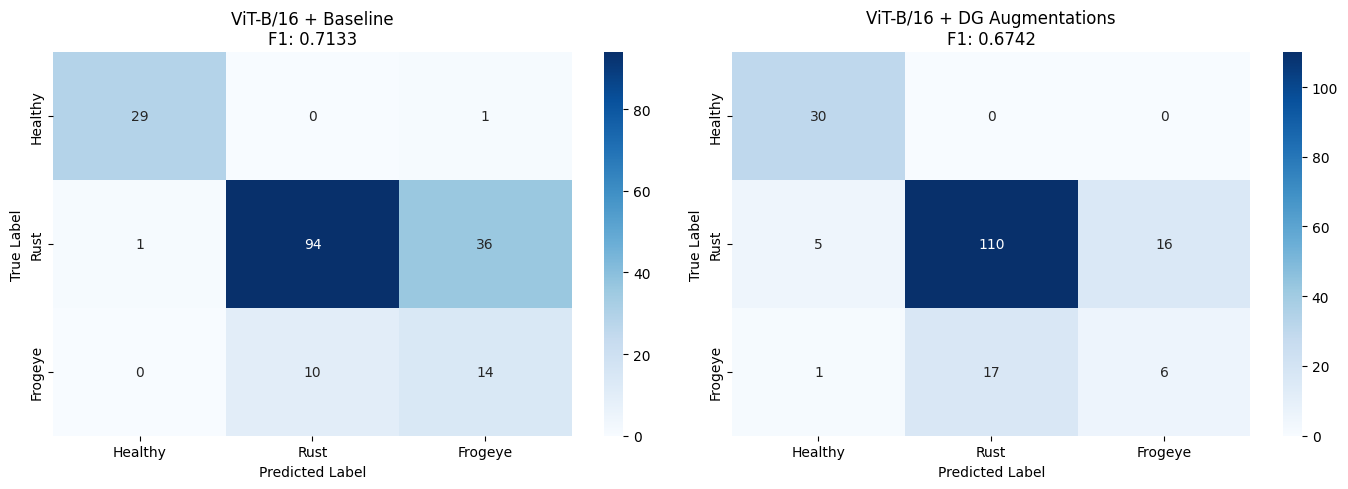


ViT-B/16 Results Summary (MH Cross-Domain)
Baseline F1:       0.7133
DG F1:             0.6742
Improvement:       -0.0391 (-5.5%)

❌ DG augmentations did not improve performance


In [22]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(vit_cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Healthy', 'Rust', 'Frogeye'],
            yticklabels=['Healthy', 'Rust', 'Frogeye'])
axes[0].set_title(f'ViT-B/16 + Baseline\nF1: {vit_metrics_baseline["f1"]:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(vit_cm_dg, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Healthy', 'Rust', 'Frogeye'],
            yticklabels=['Healthy', 'Rust', 'Frogeye'])
axes[1].set_title(f'ViT-B/16 + DG Augmentations\nF1: {vit_metrics_dg["f1"]:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'vit_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare F1 scores
vit_f1_improvement = vit_metrics_dg['f1'] - vit_metrics_baseline['f1']
print(f"\n{'='*70}")
print(f"ViT-B/16 Results Summary (MH Cross-Domain)")
print(f"{'='*70}")
print(f"Baseline F1:       {vit_metrics_baseline['f1']:.4f}")
print(f"DG F1:             {vit_metrics_dg['f1']:.4f}")
print(f"Improvement:       {vit_f1_improvement:+.4f} ({vit_f1_improvement/vit_metrics_baseline['f1']*100:+.1f}%)")
print(f"{'='*70}")

if vit_f1_improvement > 0.03:
    print("\n✅ DG augmentations provide significant improvement!")
elif vit_f1_improvement > 0:
    print("\n⚠️ DG augmentations provide modest improvement")
else:
    print("\n❌ DG augmentations did not improve performance")

## Final Summary: Style Randomization Results

Compare both models with baseline vs DG augmentations.

In [23]:
# Create summary table
summary_data = {
    'Model': ['ResNet50', 'ResNet50', 'ViT-B/16', 'ViT-B/16'],
    'Augmentation': ['Baseline', 'DG (Heavy)', 'Baseline', 'DG (Heavy)'],
    'MH F1': [
        metrics_baseline['f1'],
        metrics_dg['f1'],
        vit_metrics_baseline['f1'],
        vit_metrics_dg['f1']
    ],
    'MH Accuracy': [
        metrics_baseline['accuracy'],
        metrics_dg['accuracy'],
        vit_metrics_baseline['accuracy'],
        vit_metrics_dg['accuracy']
    ],
    'Improvement': [
        '-',
        f"{resnet_f1_improvement:+.4f}",
        '-',
        f"{vit_f1_improvement:+.4f}"
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("STYLE RANDOMIZATION EXPERIMENT - FINAL RESULTS")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Save summary
df_summary.to_csv(RESULTS_DIR / 'style_randomization_summary.csv', index=False)
print(f"\n💾 Summary saved to: {RESULTS_DIR / 'style_randomization_summary.csv'}")

# Key insights
print("\n📊 Key Insights:")
print(f"   • ResNet50 improvement: {resnet_f1_improvement:+.4f} ({resnet_f1_improvement/metrics_baseline['f1']*100:+.1f}%)")
print(f"   • ViT-B/16 improvement: {vit_f1_improvement:+.4f} ({vit_f1_improvement/vit_metrics_baseline['f1']*100:+.1f}%)")

avg_improvement = (resnet_f1_improvement + vit_f1_improvement) / 2
if avg_improvement > 0.03:
    print("\n✅ Style randomization helps close the domain gap!")
    print("   → Heavy augmentations expand source distribution to cover target")
    print("   → Consider testing on DINOv2/YOLOv8 for even better results")
elif avg_improvement > 0:
    print("\n⚠️ Style randomization provides modest benefits")
    print("   → May need to combine with other techniques (TTA, domain adaptation)")
else:
    print("\n❌ Style randomization alone is insufficient")
    print("   → Domain gap may require explicit adaptation or target-domain fine-tuning")

print("\n📈 Comparison to Original Baselines (notebooks 01 & 02):")
print(f"   ResNet50 baseline: ~0.69 → DG: {metrics_dg['f1']:.4f}")
print(f"   ViT-B/16 baseline: ~0.72 → DG: {vit_metrics_dg['f1']:.4f}")


STYLE RANDOMIZATION EXPERIMENT - FINAL RESULTS
   Model Augmentation    MH F1  MH Accuracy Improvement
ResNet50     Baseline 0.742793     0.800000           -
ResNet50   DG (Heavy) 0.717810     0.794595     -0.0250
ViT-B/16     Baseline 0.713333     0.740541           -
ViT-B/16   DG (Heavy) 0.674225     0.789189     -0.0391

💾 Summary saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/style_randomization/style_randomization_summary.csv

📊 Key Insights:
   • ResNet50 improvement: -0.0250 (-3.4%)
   • ViT-B/16 improvement: -0.0391 (-5.5%)

❌ Style randomization alone is insufficient
   → Domain gap may require explicit adaptation or target-domain fine-tuning

📈 Comparison to Original Baselines (notebooks 01 & 02):
   ResNet50 baseline: ~0.69 → DG: 0.7178
   ViT-B/16 baseline: ~0.72 → DG: 0.6742
